In [1]:
!pip install timm
!pip install lightning
!pip install rasterio
!pip install torchmetrics
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 99.0 MB/s eta 0:00:00


In [2]:
import torch
import rasterio
import timm
import torch.nn as nn
import lightning as L
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchinfo import summary
import joblib
from google.colab import drive
import sys
import os
from sklearn.preprocessing import StandardScaler

In [3]:
drive.mount('/content/drive')
current_dir = '/content/drive/MyDrive/teg_resnet18_arroz/03_modelo'
directory_to_add = current_dir
sys.path.append(directory_to_add)

Mounted at /content/drive


In [4]:
import utils

In [5]:
BATCH_SIZE = 64

In [6]:
timm.list_models()

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit3_base_patch16_224',
 'beit3_giant_patch14_224',
 'beit3_giant_patch14_336',
 'beit3_large_patch16_224',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_sma

In [7]:
resnet18_model = timm.create_model("resnet18", pretrained=False, in_chans=10, num_classes=1)

In [8]:
summary(
    resnet18_model,
    input_size=(BATCH_SIZE, 10, 64, 64),
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet (ResNet)                          [64, 10, 64, 64]          [64, 1]                   --                        --                        --
├─Conv2d (conv1)                         [64, 10, 64, 64]          [64, 64, 32, 32]          31,360                    [7, 7]                    2,055,208,960
├─BatchNorm2d (bn1)                      [64, 64, 32, 32]          [64, 64, 32, 32]          128                       --                        8,192
├─ReLU (act1)                            [64, 64, 32, 32]          [64, 64, 32, 32]          --                        --                        --
├─MaxPool2d (maxpool)                    [64, 64, 32, 32]          [64, 64, 16, 16]          --                        3                         --
├─Sequential (layer1)                    [64, 64, 16, 16]          [64, 64, 16, 16]        

In [12]:
df = pd.read_csv('/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/filtered_labeled_file_2244.csv')
labels = df['label'].values.reshape(-1, 1)

In [13]:
scaler_z = StandardScaler()
labels_norm = scaler_z.fit_transform(labels)
scaler_path = '/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/scaler_z.pkl'
joblib.dump(scaler_z, scaler_path)  # Guarda para uso posterior

df['produccion_norm'] = labels_norm
df.to_csv('/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/filtered_labeled_file_2244_norm_z.csv', index=False)

In [14]:
dfn = pd.read_csv('/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/filtered_labeled_file_2244_norm_z.csv')

# Cambia los nombres
dfn = dfn.rename(columns={
    'label': 'prod',
    'produccion_norm': 'label'
})

# Guarda el resultado en otro archivo o sobreescribe
dfn.to_csv('/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/filtered_labeled_file_2244_norm_z.csv', index=False)

In [13]:
concat_seasons_dataset_list = utils.Sentinel2ConcatSeasonsRegressionDataset(
        folder_path='/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/images',
        csv='/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/filtered_labeled_file_2244_norm_z.csv'
    )
print(concat_seasons_dataset_list)

0 ; -1.7196216166563882
1 ; -1.642280858643287
2 ; 0.4105723277591793
3 ; -0.7402693450725819
4 ; -0.8644483097702339
5 ; -1.1294217344419843
6 ; -0.8329663187201249
7 ; 1.2894445779080546
8 ; -0.1351155171093761
9 ; -1.2011307140561214
10 ; -0.2208164927457839
11 ; 0.9405191771026806
12 ; -1.2098757115700407
13 ; 0.2986363595810141
14 ; -1.226491206846487
15 ; -0.8644483097702339
16 ; -1.0734537503529018
17 ; -0.947525786152466
18 ; -1.027979763280522
19 ; -1.3253096787537737
20 ; -1.0113642680040758
21 ; -0.3948419432727751
22 ; 0.205939385933471
23 ; -0.905549798085654
24 ; -0.7026658557627294
25 ; 0.0257924371467363
26 ; -0.0870180307828207
27 ; 0.8102187141452848
28 ; 0.0214199383897767
29 ; -0.8889343028092075
30 ; 0.4656658120968699
31 ; -1.0996887428946591
32 ; -0.3126389666419351
33 ; -0.4009634415325185
34 ; 1.543924005563102
35 ; 1.4888305212254114
36 ; 1.0314671512474394
37 ; 0.038909933417615
38 ; 1.2387235923273234
39 ; 1.4477290329099914
40 ; 1.4232430398710176
41 ; 1.41

In [14]:
print(len(concat_seasons_dataset_list))

2244


In [15]:
x, y = concat_seasons_dataset_list[0]
print(x.shape)
print(y)

torch.Size([10, 64, 64])
-1.7196216166563882


In [16]:
dataset = concat_seasons_dataset_list
dataset_size = len(concat_seasons_dataset_list)

In [17]:
train_size = int(0.8 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
print(f"Train size: {train_size}. Validation size: {val_size}. Test size: {test_size}.")

Train size: 1795. Validation size: 336. Test size: 113.


In [18]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Train size: {len(train_dataset)}. Validation size: {len(val_dataset)}. Test size: {len(test_dataset)}.")

Train size: 1795. Validation size: 336. Test size: 113.


In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
#print(f"Train size: {len(train_dataloader)}. Validation size: {len(val_dataloader)}. Test size: {len(test_dataloader)}.")
print(f"Training batches: {len(train_dataloader)}. Validation batches: {len(val_dataloader)}. Test batches: {len(test_dataloader)}.")
print(f"Train size: {len(train_dataloader) * BATCH_SIZE}. Validation size: {len(val_dataloader) * BATCH_SIZE}. Test size: {len(test_dataloader) * BATCH_SIZE}.")

Training batches: 28. Validation batches: 6. Test batches: 2.
Train size: 1792. Validation size: 384. Test size: 128.


In [20]:
batch = next(iter(train_dataloader))

In [21]:
xb, yb = batch

In [22]:
print(xb.shape)
print(yb.shape)

torch.Size([64, 10, 64, 64])
torch.Size([64])


In [23]:
yb

tensor([-1.8105,  0.9709, -0.6449,  0.9466, -1.0166,  0.8085, -0.5535, -0.6143,
        -0.6706,  0.0727,  1.1330, -0.0408,  1.4693,  1.0720, -0.4707, -0.7203,
        -0.4023,  0.5385,  1.4589,  1.3204,  2.0106, -0.0316, -0.1431, -0.3812,
         0.9405,  0.4763, -0.2086, -0.2647, -1.1041, -0.2922, -1.1740, -0.9902,
        -1.3310,  0.3853,  1.0283,  0.6602,  1.1850,  0.8495, -0.4731, -0.9502,
        -0.8490, -1.2833, -1.3627, -0.5463, -0.7178,  1.5475,  0.4236, -0.6925,
        -0.8684,  1.6652,  0.9131,  1.3272, -1.2353, -0.4926, -0.1832, -0.2290,
         1.0662, -1.0218,  0.3535,  1.2991, -0.0479, -0.5065, -0.6326,  0.5907],
       dtype=torch.float64)

In [15]:
class LightningRegressionTask(L.LightningModule):
    def __init__(self, model, model_name, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        #self.criterion = nn.MSELoss() # Cambiar perdida
        self.criterion = nn.HuberLoss()
        self.learning_rate = learning_rate
        self.name = model_name

        # Métricas de regresión
        self.mse = torchmetrics.MeanSquaredError()
        self.rmse = torchmetrics.MeanSquaredError(squared=False)
        self.mae = torchmetrics.MeanAbsoluteError()
        self.r2 = torchmetrics.R2Score()

        self.scaler = joblib.load(scaler_path)

        # Diccionarios de logs
        self.train_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}
        self.val_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}
        self.test_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}

        self.train_step_loss_logs = {"step_loss": []}
        self.val_step_loss_logs = {"step_loss": []}
        self.test_step_loss_logs = {"step_loss": []}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1) # Asegúrate de que las dimensiones coincidan
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        # Métricas de regresión
        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        # Log de métricas
        self.log("train_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.train_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_train_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.train_logs["epoch"].append(epoch)
        self.train_logs["loss"].append(self.trainer.callback_metrics["train_loss"].item())
        self.train_logs["mse"].append(self.trainer.callback_metrics["train_mse"].item())
        self.train_logs["rmse"].append(self.trainer.callback_metrics["train_rmse"].item())
        self.train_logs["mae"].append(self.trainer.callback_metrics["train_mae"].item())
        self.train_logs["r2"].append(self.trainer.callback_metrics["train_r2"].item())

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        # Métricas de regresión
        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        self.log("val_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_validation_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.val_logs["epoch"].append(epoch)
        self.val_logs["loss"].append(self.trainer.callback_metrics["val_loss"].item())
        self.val_logs["mse"].append(self.trainer.callback_metrics["val_mse"].item())
        self.val_logs["rmse"].append(self.trainer.callback_metrics["val_rmse"].item())
        self.val_logs["mae"].append(self.trainer.callback_metrics["val_mae"].item())
        self.val_logs["r2"].append(self.trainer.callback_metrics["val_r2"].item())

    def on_fit_end(self):
        # Export logs
        train_logs_df = pd.DataFrame(self.train_logs)
        train_step_loss_logs_df = pd.DataFrame(self.train_step_loss_logs)
        train_logs_df.to_csv(f"logs-{self.name}/training_logs_{self.name}.csv", index=False)
        train_step_loss_logs_df.to_csv(f"logs-{self.name}/training_step_loss_logs_{self.name}.csv", index=False)

        val_logs_df = pd.DataFrame(self.val_logs)
        val_step_loss_logs_df = pd.DataFrame(self.val_step_loss_logs)
        val_logs_df.to_csv(f"logs-{self.name}/validation_logs_{self.name}.csv", index=False)
        val_step_loss_logs_df.to_csv(f"logs-{self.name}/validation_step_loss_logs_{self.name}.csv", index=False)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        self.log("test_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.test_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_test_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.test_logs["epoch"].append(epoch)
        self.test_logs["loss"].append(self.trainer.callback_metrics["test_loss"].item())
        self.test_logs["mse"].append(self.trainer.callback_metrics["test_mse"].item())
        self.test_logs["rmse"].append(self.trainer.callback_metrics["test_rmse"].item())
        self.test_logs["mae"].append(self.trainer.callback_metrics["test_mae"].item())
        self.test_logs["r2"].append(self.trainer.callback_metrics["test_r2"].item())

    def on_test_end(self):
        test_logs_df = pd.DataFrame(self.test_logs)
        test_step_loss_logs_df = pd.DataFrame(self.test_step_loss_logs)
        test_logs_df.to_csv(f"logs-{self.name}/test_logs_{self.name}.csv", index=False)
        test_step_loss_logs_df.to_csv(f"logs-{self.name}/test_step_loss_logs_{self.name}.csv", index=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def predict_step(self, batch, batch_idx):
      x = batch if len(batch) == 1 else batch[0]
      y_pred_norm = self(x)
      if self.scaler:
          y_pred_real = self.scaler.inverse_transform(y_pred_norm.detach().cpu().numpy())
          return y_pred_real
      return y_pred_norm

In [16]:
lightning_resnet18_model = LightningRegressionTask(resnet18_model, "resnet18", learning_rate=0.001)

In [26]:
# callbacks_list_resnet18 = [
#     ModelCheckpoint(
#         save_top_k=3,
#         filename="{epoch}---{val_rmse:.2f}---{val_loss:.2f}",
#         mode="min", monitor="val_loss",
#         save_last=True
#         )
# ]

early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=10, verbose=True)
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
        filename="{epoch}---{val_rmse:.2f}---{val_loss:.2f}",
        mode="min", monitor="val_loss",
        save_last=True
)

In [27]:
trainer = L.Trainer(
    max_epochs=100,  # Number of epochs to train
    accelerator="gpu",  # Use GPU if available, or "cpu" for CPU
    devices=1,  # Number of GPUs to use (set to 1 for a single GPU)
    log_every_n_steps=50,  # Log metrics every 50 steps
    callbacks=[early_stopping, checkpoint_callback],  # Set callbacks
    default_root_dir="logs-resnet18/"
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(lightning_resnet18_model, train_dataloader, val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | criterion | HuberLoss         | 0      | train
2 | mse       | MeanSquaredError  | 0      | train
3 | rmse      | MeanSquaredError  | 0      | train
4 | mae       | MeanAbsoluteError | 0      | train
5 | r2        | R2Score           | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.796    Total estimated model params size (MB)
99        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.095
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.061
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.061


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.052
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.052


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.052
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.052


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 0.052. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.052. Signaling Trainer to stop.


In [29]:
trainer.test(lightning_resnet18_model, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06610359251499176    │
│         test_mae          │    0.26600712537765503    │
│         test_mse          │     0.133132204413414     │
│          test_r2          │     0.84344482421875      │
│         test_rmse         │    0.3572750985622406     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06610359251499176,
  'test_mse': 0.133132204413414,
  'test_rmse': 0.3572750985622406,
  'test_mae': 0.26600712537765503,
  'test_r2': 0.84344482421875}]

In [30]:
!cp -r logs-resnet18/ /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/

In [17]:
logs_path = "/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/"

Gráfica loss guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/loss.png


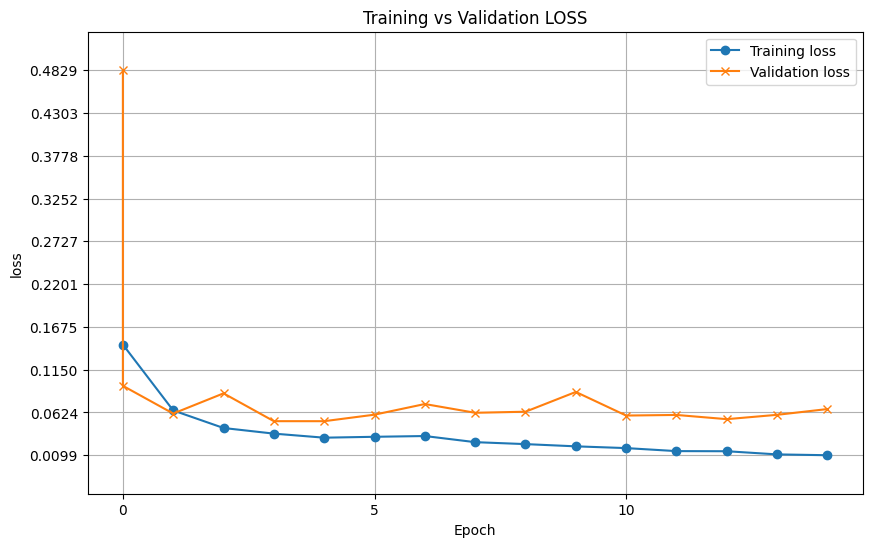

Gráfica mse guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/mse.png


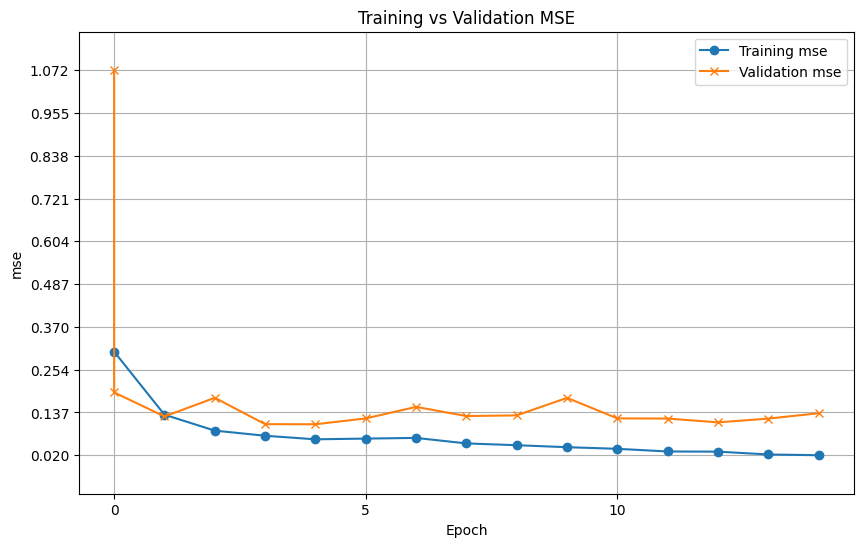

Gráfica rmse guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/rmse.png


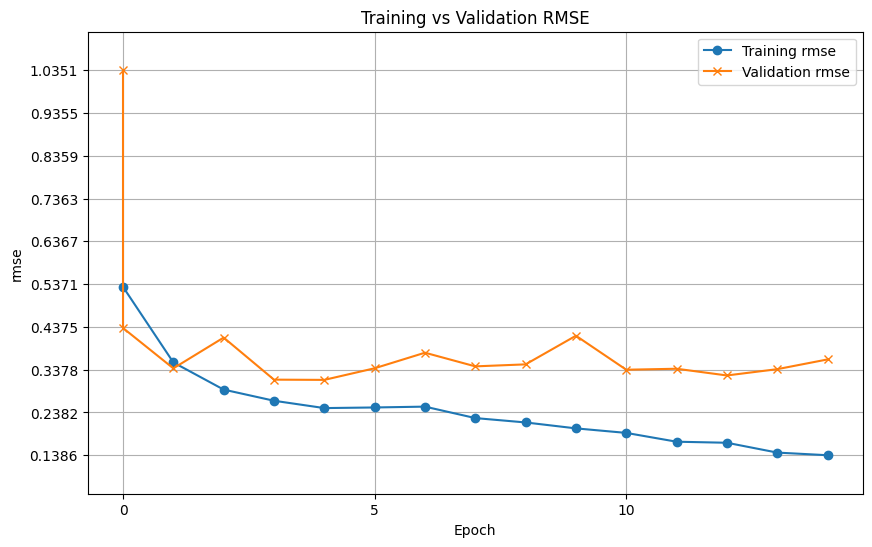

Gráfica mae guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/mae.png


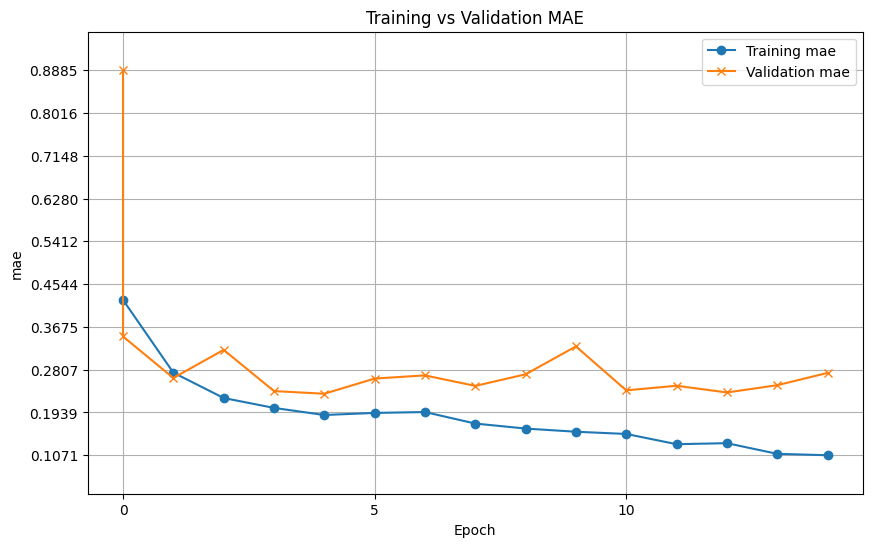

Gráfica r2 guardada en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/r2.png


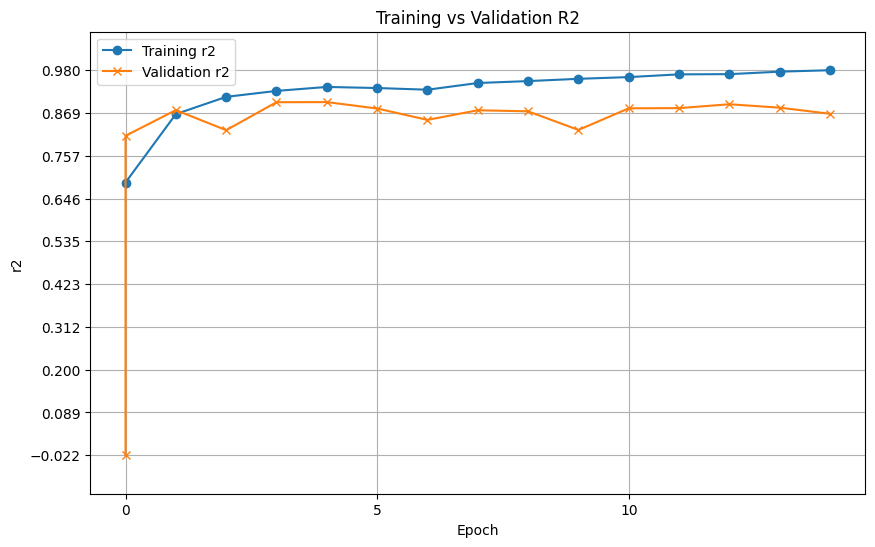

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Nombres de los archivos CSV de training y validation
train_csv = logs_path + "/training_logs_resnet18.csv"
val_csv = logs_path + "/validation_logs_resnet18.csv"

# Cargar datos
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

# Métricas a graficar
metrics = ["loss", "mse", "rmse", "mae", "r2"]

# Rango de epocas para ticks en X
epoch_min = min(train_df['epoch'].min(), val_df['epoch'].min())
epoch_max = max(train_df['epoch'].max(), val_df['epoch'].max())

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['epoch'], train_df[metric], label='Training '+metric, marker='o')
    plt.plot(val_df['epoch'], val_df[metric], label='Validation '+metric, marker='x')
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric.upper()}")
    plt.legend()
    plt.grid(True)

    ymin, ymax = min(train_df[metric].min(), val_df[metric].min()), max(train_df[metric].max(), val_df[metric].max())
    ymargin = (ymax - ymin) * 0.1
    plt.ylim(ymin - ymargin, ymax + ymargin)
    plt.yticks(np.linspace(ymin, ymax, 10))
    plt.xticks(np.arange(epoch_min, epoch_max + 1, 5))
       # Guardar la gráfica en logs_path con nombre basado en la métrica
    filename = os.path.join(logs_path, f"{metric}.png")
    plt.savefig(filename)
    #plt.close()

    print(f"Gráfica {metric} guardada en: {filename}")
    plt.show()

# Eligiendo modelo a probar

In [27]:
# Ruta al checkpoint .ckpt
ckpt_path = "//content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/lightning_logs/version_0/checkpoints/last.ckpt"
epoca = "last"

# Guardar a .pth

In [ ]:
# Carga del checkpoint
checkpoint = torch.load(ckpt_path, map_location='cpu')

# Cargar solo el diccionario de pesos
lightning_resnet18_model.load_state_dict(checkpoint['state_dict'])

lightning_resnet18_model.eval()

LightningRegressionTask(
  (model): ResNet(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
torch.save(checkpoint['state_dict'], '/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_mm/lightning_logs/version_0/checkpoints/epoch_' + epoca + '.pth')

# Probando modelo

In [28]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import pytorch_lightning as L
import joblib

class SatelliteDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        import rasterio
        row = self.data.iloc[idx]
        img_path = f"{self.root_dir}/{row['filename']}"
        with rasterio.open(img_path) as src:
            img = src.read()  # (bands, H, W)
        if self.transform:
            img = self.transform(img)
        label = row['label']
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [29]:
# Parámetros
csv_file = "/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/sample_100.csv"
image_root_dir = "/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/images"
#ckpt_path = "modelo.ckpt"
#batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# Crear dataset y dataloader
dataset = SatelliteDataset(csv_file, image_root_dir)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
# Cargar modelo Lightning con checkpoint .ckpt
model = LightningRegressionTask.load_from_checkpoint(ckpt_path, model=resnet18_model, model_name="resnet18")
model.to(device)
model.eval()

LightningRegressionTask(
  (model): ResNet(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [32]:
# Obtener predicciones y etiquetas reales
from tqdm import tqdm

preds = []
trues = []
with torch.no_grad():
    for inputs, labels in tqdm(dataloader, desc="Inferencia"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs_norm = model(inputs)
        outputs = model.scaler.inverse_transform(outputs_norm.cpu().numpy())
        preds.extend(outputs.flatten())
        trues.extend(labels.cpu().numpy().flatten())

preds = np.array(preds)
trues = np.array(trues)

Inferencia: 100%|██████████| 2/2 [00:28<00:00, 14.45s/it]


In [33]:
# Calcular métricas
n = preds.size
p = 10
r2 = r2_score(trues, preds)
mae = mean_absolute_error(trues, preds)
perc_error = np.mean(np.abs((trues - preds) / trues)) * 100
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R2 score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Porcentaje de Error: {perc_error:.2f}%")
print(f"R2 ajustado: {r2_adj:.4f}")

# Crear un diccionario con las métricas
metrics_dict = {
    'R2': [r2],
    'MAE': [mae],
    'Porcentaje_Error': [perc_error],
    'R2_Ajustado': [r2_adj]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Ruta del archivo CSV
csv_path = os.path.join(logs_path, "metricas_resultado_epoch_" + epoca + ".csv")

# Guardar DataFrame en CSV (sobrescribe si existe)
metrics_df.to_csv(csv_path, index=False)

print(f"Métricas guardadas en: {csv_path}")

R2 score: 0.8994
MAE: 19313.0020
Porcentaje de Error: 13.86%
R2 ajustado: 0.8881
Métricas guardadas en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_z/metricas_resultado_epoch_last.csv


In [34]:
 #Guardar resultados con predicciones y error
results_df = pd.read_csv(csv_file)
results_df['produccion_predicha'] = preds
results_df['error_porcentual'] = np.abs((results_df['label'] - preds) / results_df['label']) * 100
results_df.to_csv(logs_path + "/resultados_predicciones_epoch_" + epoca + ".csv", index=False)

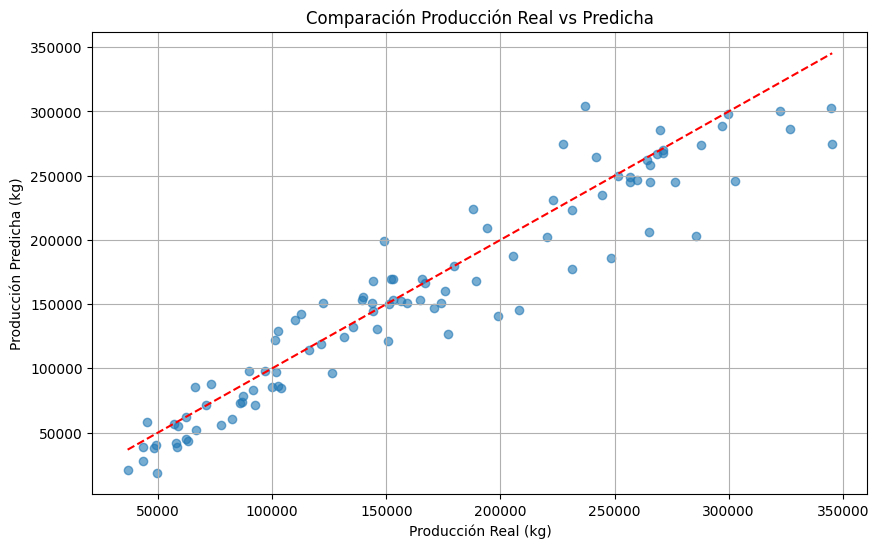

In [35]:
# Graficar comparación real vs predicha
plt.figure(figsize=(10,6))
plt.scatter(trues, preds, alpha=0.6)
plt.plot([min(trues), max(trues)], [min(trues), max(trues)], 'r--')
plt.xlabel("Producción Real (kg)")
plt.ylabel("Producción Predicha (kg)")
plt.title("Comparación Producción Real vs Predicha")
plt.grid(True)
plt.savefig(logs_path + "/comparacion_real_vs_predicha_epoch_" + epoca + ".png")
plt.show()